![Clase aprendizaje no supervisado](https://raw.githubusercontent.com/MECA4605-Aprendizaje-no-supervisado/taller_4/main/figs/taller-meca-aprendizaje%20no%20supervisado_banner%201169%20x%20200%20px%20-05.png)

# Caso-taller: Identificando  Burger Master con MMG

El Burger Master es un evento creado en el 2016 por el *influencer* Tulio Zuluaga, más conocido en redes como Tulio recomienda, el cual busca que por una semana las hamburgueserías de cada ciudad ofrezcan su mejor producto a un precio reducido.

El evento ha venido creciendo y en el 2022 se extendió por 21 ciudades de Colombia para las cuales se estimó que se vendieron más de dos millones de hamburguesas. El objetivo del presente caso-taller  es identificar los puntos calientes de hamburgueserías  que compitieron en  la ciudad de Bogotá aplicando el Modelo de Mezclas Gaussianas.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo

### 1. Carga de datos  

En la carpeta `data` se encuentra el archivo `burger_master.xlsx` para la ciudad de Bogotá, cargue estos datos en su *cuaderno* y reporte brevemente el contenido de la base.

In [6]:
# Cargamos los paquetes
import pandas as pd
import numpy as np

In [7]:
# Cargamos los datos de la base burguer_master.xlsx
burguer = pd.read_excel('https://github.com/sebastian23escobar/Aprendizaje_no_supervisado/raw/refs/heads/main/Taller4/data/burger_master.xlsx')
burguer.head()

,Restaurante,Dirección,Descripción,Latitud,Longitud
0,MAIKKI,Cra 75 # 24D – 48,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.668833,-74.116828
1,MAIKKI,Calle 119 # 11A – 24,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.698395,-74.036585
2,MAIKKI,Cra 47A # 98 – 47,"<p>MAIKKI MACUIRA: Cama de chicharrón soplado,...",4.686401,-74.060144
3,FRENCHEESE,Calle 51 #22-55,"<p>Presentamos «La French Master», inspirada e...",4.639514,-74.073545
4,FRENCHEESE,Calle 80 #14-41,"<p>Presentamos «La French Master», inspirada e...",4.666147,-74.056758


Se cargan los paquetes necesarios y se llama el archivo desde el repositorio de Github, luego se muestra brevemente la información con la instrucción head

### 2.  Visualizando los datos

Visualice la ubicación de cada restaurante en un mapa interactivo. Añada un marcador para cada restaurante y la posibilidad de encontrar la descripción de la hamburguesa ofrecida en un pop-up. (Note que la columna Descripción contiene otra información adicional).

In [8]:
#importamos la librería
import folium

#Mapa base
map = folium.Map(location = [4.6688326,-74.11682789999999], tiles = "OpenStreetMap", zoom_start = 12)
# Otras opciones de tiles
#Stamen Terrain, Toner, and Watercolor

#capa bares
for i in range(0,len(burguer)):
   folium.Marker(
      location=[burguer.iloc[i]['Latitud'], burguer.iloc[i]['Longitud']],
       popup=burguer.iloc[i]['Descripción'],
   ).add_to(map)


#Display el mapa
map

Utilizamos la librería folium en donde se indica que queremos centrar el mapa en las coordenadas 4.6688326,-74.11682789999999, luego, agregamos una capa con las ubicaciones de los restaurantes (indicando la columna de latitud y longitud, finalmente indicamos que los popups deben contener la información de la columna "Descripción".

### 3.  Análisis de puntos calientes

Aplique el modelo de Mezclas Gaussianas para buscar clusters de restaurantes en Bogotá, mencione qué estructura de covarianza usó y explique por qué. Escoja el número óptimo de componentes, explicando el procedimiento y justificando su elección.

In [22]:
# Importamos los paquetes de MMG y relacionados
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt


In [23]:
restaurantes = burguer[['Latitud', 'Longitud']]

In [24]:
MMG_restaurantes = GaussianMixture(n_components = 2, covariance_type='full', random_state = 1234).fit(restaurantes)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [25]:
#Definimos una función que nos permite crear las curvas de nivel a través de elipses:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Dibuja un elipse dado la media y varianza"""
    ax = ax or plt.gca()

    # Convierte las covarianzas
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Dibuja el elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(xy=position, width=nsig * width, height=nsig * height,
                     angle=angle, **kwargs))
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


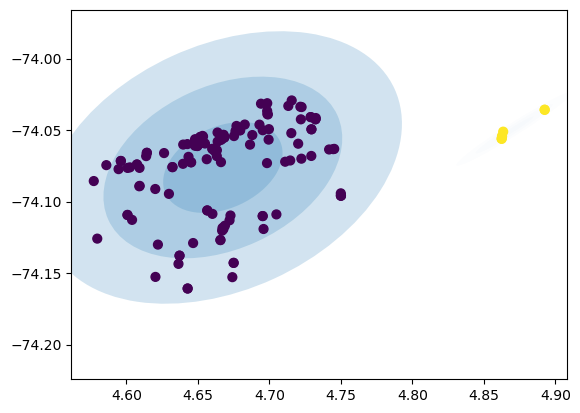

In [26]:
# Graficamos
plot_gmm(MMG_restaurantes, restaurantes)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\App

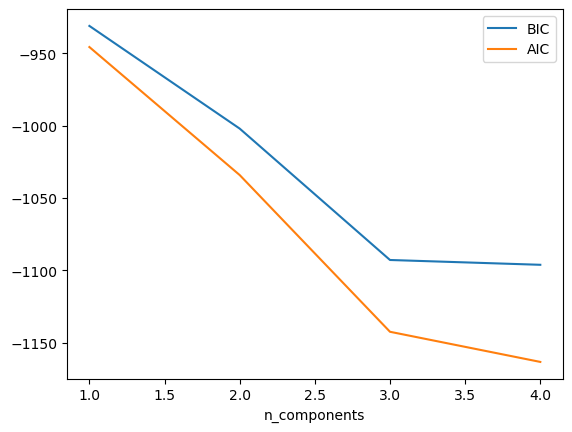

In [29]:
n_components = np.arange(1, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(restaurantes)
          for n in n_components]

plt.plot(n_components, [m.bic(restaurantes) for m in models], label='BIC')
plt.plot(n_components, [m.aic(restaurantes) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


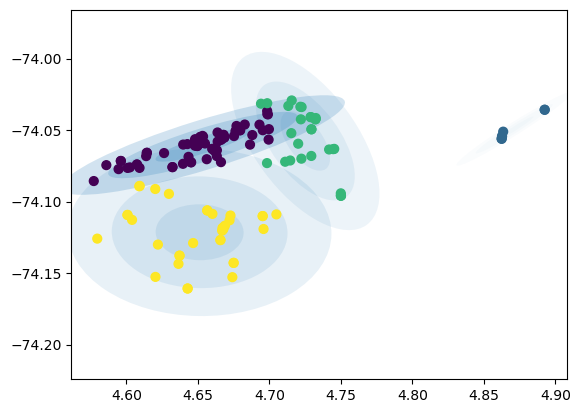

In [31]:
from sklearn.mixture import GaussianMixture

MMG_homicidios3 = GaussianMixture(n_components = 4, covariance_type='full', random_state = 0).fit(restaurantes)

# Graficamos
plot_gmm(MMG_homicidios3, restaurantes)

### Que matriz de covarianza debemos usar?

In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 5),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(restaurantes)

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\App

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 5)},
             scoring=<function gmm_bic_score at 0x00000237E69719E0>)

In [33]:
df_search = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_search["mean_test_score"] = df_search["mean_test_score"]
df_search = df_search.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_search.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
15,4,full,109.430416
3,4,spherical,127.992168
11,4,diag,129.172706
2,3,spherical,150.567237
10,3,diag,159.645383


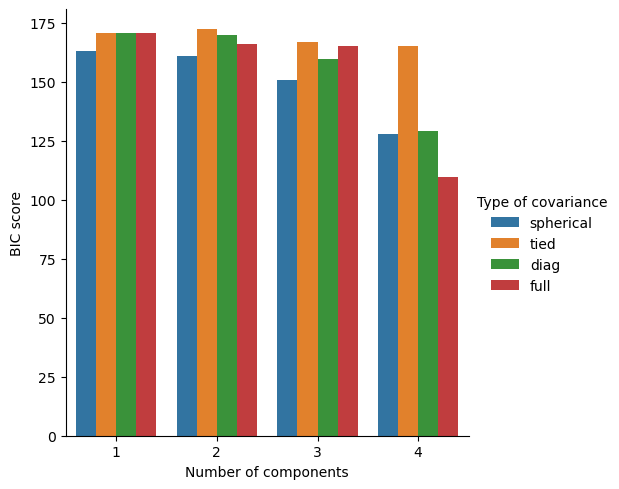

In [34]:
import seaborn as sns

sns.catplot(
    data=df_search,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\ypalacios\AppData\Local\miniforge3\envs\myenvironment\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


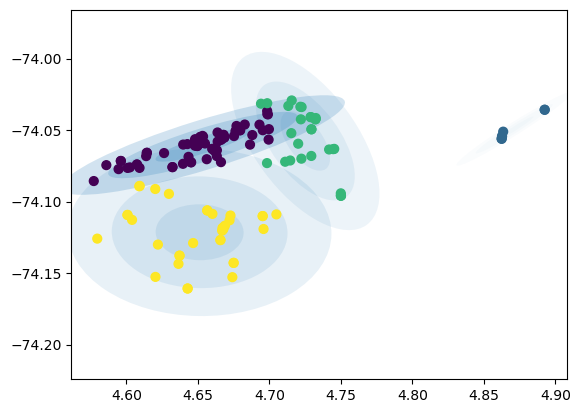

In [35]:
MMG_homicidios4 = GaussianMixture(n_components = 4, covariance_type='full', random_state = 0).fit(restaurantes)

# Graficamos
plot_gmm(MMG_homicidios4, restaurantes)

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

#### 3.1. Visualización de los resultados

Visualice las densidades estimadas por el  mejor modelo estimado en la sección anterior usando un mapa de calor interactivo, discuta los resultados.

In [ ]:
#Mapa base
map = folium.Map(location = [4.6688326,-74.11682789999999], tiles = "OpenStreetMap", zoom_start = 12)
# Otras opciones de tiles
#Stamen Terrain, Toner, and Watercolor

#capa bares
for i in range(0,len(burguer)):
   folium.Marker(
      location=[burguer.iloc[i]['Latitud'], burguer.iloc[i]['Longitud']],
   ).add_to(map)

# Empaquetar los datos: [lat, lon, densidad]
heat_data = [[lat, lon, dens] for (lon, lat), dens in zip(grid, densidades)]

#Display el mapa
map

In [ ]:

map = folium.Map(location = [41.881998,-87.627800], tiles = "OpenStreetMap", zoom_start = 10)


#Agregamos la capa de polígonos con un popup con el nombre del area comunitaria
for _, r in barrios.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#FFFFFF'})
    folium.Popup(r['community']).add_to(geo_j)
    geo_j.add_to(map)
folium.GeoJson(
    geojson_normal_reference,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
         'fillColor': x['properties']['fill'],
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(map)

map

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 4. Comparación con KDE

Estime ahora las densidades usando KDE bivariado de la librería `statsmodels` con el anchos de banda dado por `cv_ml`. Muestre los resultados usando un mapa interactivo. Compare los resultados obtenidos por el "mejor" modelo encontrado via MMG.

In [ ]:
# Utilice este espacio para escribir el código.

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)